# Regression

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

## Load Data

In [3]:
diabetes_dataset = load_diabetes(as_frame=True, scaled=False)
# print(diabetes_dataset.DESCR)

df = diabetes_dataset.frame.copy()

target_column_name = "target"
feature_column_names = [col for col in df.columns if col != target_column_name]

X_full = df[feature_column_names]
y_full = df[target_column_name]

display(df.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (353, 10)
Test shape: (89, 10)


## EDA

In [5]:
print("Missing values per column (train):")
print(X_train.isna().sum())

display(X_train.describe().T)

Missing values per column (train):
age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
age,353.0,48.915014,12.755285,19.0000,40.0000,51.0000,59.0000,79.000
sex,353.0,1.470255,0.499823,1.0000,1.0000,1.0000,2.0000,2.000
bmi,353.0,26.536827,4.386226,18.1000,23.4000,25.9000,29.4000,41.300
bp,353.0,94.989575,14.078076,62.0000,84.0000,93.0000,105.0000,133.000
s1,353.0,188.736544,34.729249,110.0000,163.0000,186.0000,208.0000,301.000
s2,353.0,114.924363,30.420845,41.6000,94.6000,112.8000,132.8000,242.400
s3,353.0,49.519830,12.777917,22.0000,41.0000,48.0000,57.0000,99.000
s4,353.0,4.080453,1.295082,2.0000,3.0000,4.0000,5.0000,9.090
s5,353.0,4.654751,0.524686,3.2581,4.2767,4.6347,5.0106,6.107
s6,353.0,91.716714,11.680120,58.0000,84.0000,92.0000,99.0000,124.000


<Axes: >

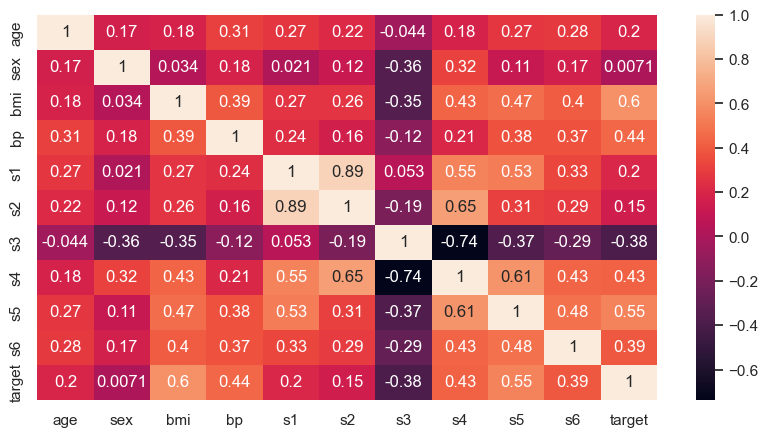

In [6]:
train_df_for_eda = X_train.copy()
train_df_for_eda[target_column_name] = y_train

correlation_matrix = train_df_for_eda.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(correlation_matrix, annot=True, ax=ax)

In [7]:
y_train.head()

17     144.0
66     150.0
137    280.0
245    125.0
31      59.0
Name: target, dtype: float64

In [8]:
y_train.describe()

count    353.000000
mean     153.736544
std       78.061902
min       25.000000
25%       86.000000
50%      142.000000
75%      214.000000
max      346.000000
Name: target, dtype: float64

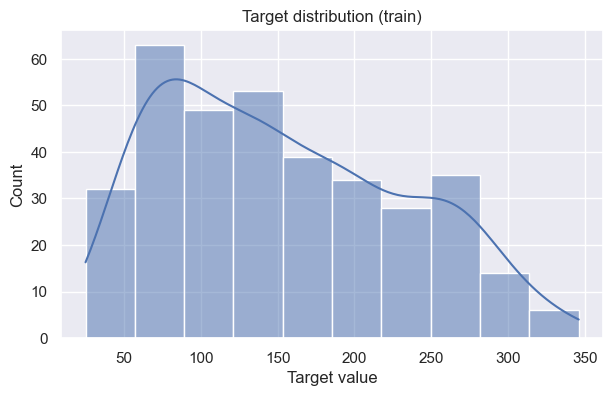

In [9]:
plt.figure(figsize=(7,4))
sns.histplot(y_train, kde=True)
plt.title("Target distribution (train)")
plt.xlabel("Target value")
plt.show()

Text(0, 0.5, 'Desease Progression')

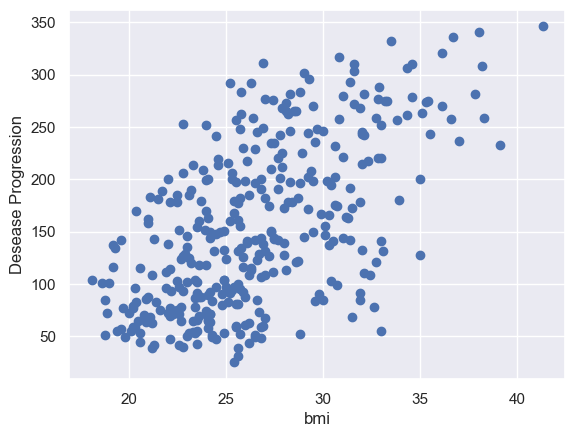

In [11]:
plt.scatter(train_df_for_eda["bmi"], train_df_for_eda["target"])
plt.xlabel("bmi")
plt.ylabel("Desease Progression")

## Metrics-funktion

In [14]:
def evaluate_regression_model(y_true, y_pred, model_name: str) -> dict:
    """
    Utvärdera en regressionsmodell med flera vanliga mått.
    Returnerar en dict med RMSE, MAE, R2
    """

    # rmse = mean_squared_error(y_true, y_pred, squared=False)
    rmse = root_mean_squared_error(y_true, y_pred)

    mae = mean_absolute_error(y_true, y_pred)

    r2 = r2_score(y_true, y_pred)

    return {"model": model_name, "RMSE": rmse, "MAE": mae, "R2": r2}

## Baseline: DummyRegressor

In [15]:
baseline_model = DummyRegressor(strategy="mean")

# FIT betyder: lär sig från träningsdata
baseline_model.fit(X_train, y_train)

# PREDICT betyder: skapa prediktioner för ny data
baseline_predictions_test = baseline_model.predict(X_test)

baseline_results = evaluate_regression_model(
    y_true=y_test,
    y_pred=baseline_predictions_test,
    model_name="Baseline (mean)"
)

baseline_results

{'model': 'Baseline (mean)',
 'RMSE': 73.22249283682244,
 'MAE': 64.00646146990485,
 'R2': -0.011962984778542296}

## CV-Strategi

In [17]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

## Pipeline

Vi använder Pipeline för att kedja preprocessing + modell

**Varför är detta viktigt?**
- Vi vill undvika "data leakage"
- Vid cross validation måste scaling tränas på träningsfolden och sedan användas på valideringsfolden
- Pipeline gört detta automatiskt på rätt sätt

In [18]:
def run_grid_search(pipeline: Pipeline, param_grid: dict, model_name: str) -> GridSearchCV:
    """
    Kör GridSearchCV för en given pipeline och parameter-grid.
    Returnerar GridSearchCV-objektet som innehåller:
    - best_params_
    - best_score_
    - best_estimator_
    """

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=cv_strategy,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print(f"\n=== {model_name} ===")
    print("Best CV RMSE:", -grid_search.best_score_)
    print("Best params:", grid_search.best_params_)

    return grid_search

## Linear Regression

In [20]:
linear_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linear_grid = GridSearchCV(
        estimator=linear_pipeline,
        param_grid={},
        scoring="neg_root_mean_squared_error",
        cv=cv_strategy,
        n_jobs=-1
    )

linear_grid.fit(X_train, y_train)

print("Linear Regression - CV RMSE:", -linear_grid.best_score_)

Linear Regression - CV RMSE: 55.39463332801855


## Ridge Regression

In [23]:
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge())
])

ridge_param_grid = {
    "model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
}

ridge_grid = run_grid_search(
    pipeline=ridge_pipeline,
    param_grid=ridge_param_grid,
    model_name="Ridge Regression"
)


=== Ridge Regression ===
Best CV RMSE: 55.37417536867347
Best params: {'model__alpha': 1.0}


## Lasso

In [24]:
lasso_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(max_iter=10000))
])

lasso_param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0]
}

lasso_grid = run_grid_search(
    pipeline=lasso_pipeline,
    param_grid=lasso_param_grid,
    model_name="Lasso Regression"
)


=== Lasso Regression ===
Best CV RMSE: 55.35395763480328
Best params: {'model__alpha': 0.1}


## Elastic Net

In [25]:
elastic_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=10000))
])

elastic_param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1.0, 10.0],
    "model__l1_ratio": [0.1, 0.5, 0.9]
}

elastic_grid = run_grid_search(
    pipeline=elastic_pipeline,
    param_grid=elastic_param_grid,
    model_name="Elastic Net"
)


=== Elastic Net ===
Best CV RMSE: 55.3762871538049
Best params: {'model__alpha': 0.01, 'model__l1_ratio': 0.5}


In [26]:
cv_results = []

cv_results.append({"model": "Linear Regression", "CV_RMSE": -linear_grid.best_score_})
cv_results.append({"model": "Ridge", "CV_RMSE": -ridge_grid.best_score_})
cv_results.append({"model": "Lasso", "CV_RMSE": -lasso_grid.best_score_})
cv_results.append({"model": "Elastic Net", "CV_RMSE": -elastic_grid.best_score_})

cv_results_df = pd.DataFrame(cv_results).sort_values("CV_RMSE")
cv_results_df

,model,CV_RMSE
2,Lasso,55.353958
1,Ridge,55.374175
3,Elastic Net,55.376287
0,Linear Regression,55.394633


## Välj bäst modell

In [27]:
best_model_name = cv_results_df.iloc[0]["model"]
print("Best model according to CV:", best_model_name)

best_estimator_lookup = {
    "LinearRegression": linear_grid.best_estimator_,
    "Ridge": ridge_grid.best_estimator_,
    "Lasso": lasso_grid.best_estimator_,
    "Elastic Net": elastic_grid.best_estimator_,
}

best_model = best_estimator_lookup[best_model_name]
best_model

Best model according to CV: Lasso


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"alpha alpha: float, default=1.0Constant that multiplies the L1 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Lasso` object is not advised.Instead, you should use the :class:`LinearRegression` object.",0.1
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.",False
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True


## Sluttest på testdata

In [28]:
test_predictions = best_model.predict(X_test)

test_results = evaluate_regression_model(
    y_true=y_test,
    y_pred=test_predictions,
    model_name=f"Best model on test: {best_model_name}"
)

test_results

{'model': 'Best model on test: Lasso',
 'RMSE': 53.70869844573793,
 'MAE': 42.805234446768836,
 'R2': 0.45554139902790414}

## Jämför med baseline

In [29]:
comparison_results = [
    baseline_results,
    test_results
]

pd.DataFrame(comparison_results)

,model,RMSE,MAE,R2
0,Baseline (mean),73.222493,64.006461,-0.011963
1,Best model on test: Lasso,53.708698,42.805234,0.455541


## Residualer (fel)

Residual = `y_true - y_pred`

Varför tittar vi på residualer?
- Vi vill se om felen verkar slumpmässiga
- Om felen har mönster kan det betyda att modellen missar något
- Vi kan upptäcka ouliers eller systematiska bias

### Rsidualplot

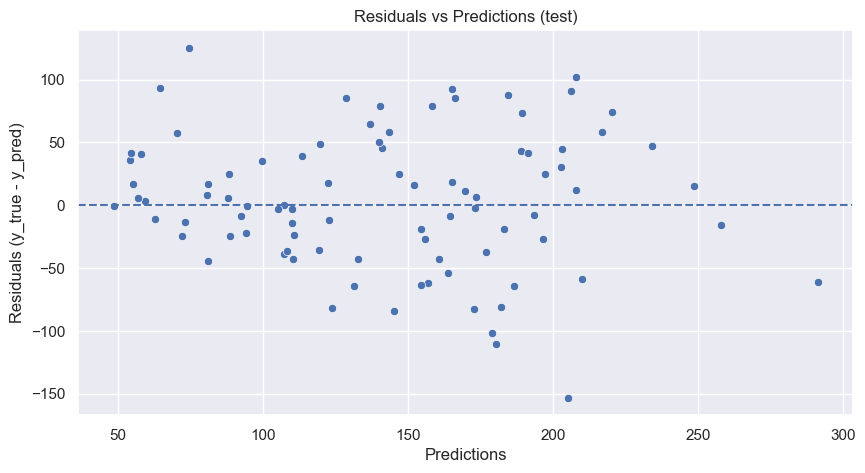

In [30]:
residuals = y_test - test_predictions

plt.figure(figsize=(10, 5))
sns.scatterplot(x=test_predictions, y=residuals)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Predictions (test)")
plt.xlabel("Predictions")
plt.ylabel("Residuals (y_true - y_pred)")
plt.show()

### Residualfördelning

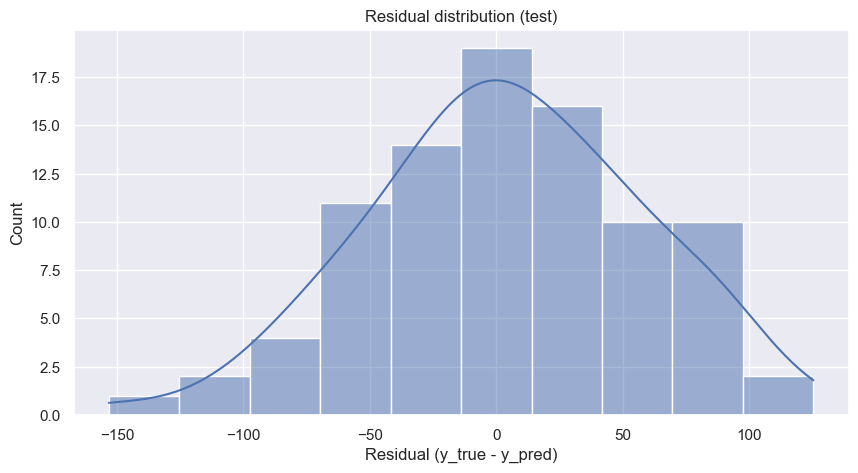

In [31]:
plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True)
plt.title("Residual distribution (test)")
plt.xlabel("Residual (y_true - y_pred)")
plt.show()

In [32]:
feature_column_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

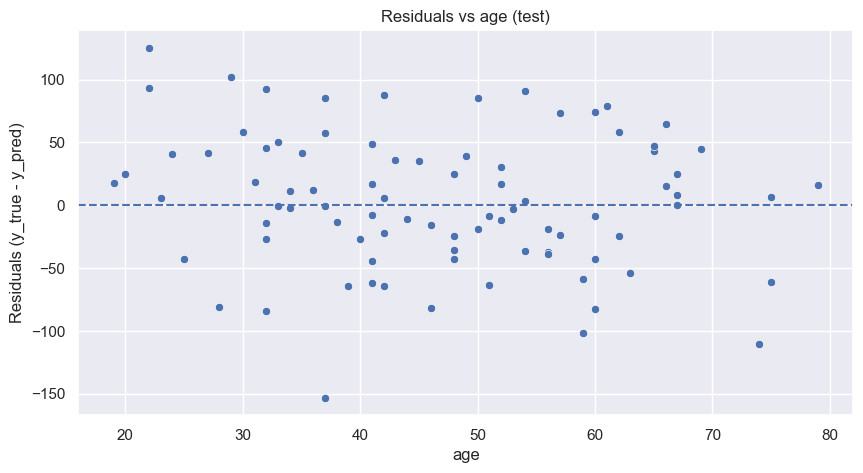

In [37]:
feature_to_inspect = feature_column_names[0]

plt.figure(figsize=(10,5))
sns.scatterplot(x=X_test[feature_to_inspect], y=residuals)
plt.axhline(0, linestyle="--")
plt.title(f"Residuals vs {feature_to_inspect} (test)")
plt.xlabel(feature_to_inspect)
plt.ylabel("Residuals (y_true - y_pred)")
plt.show()